In [1]:
import os
print(os.getcwd())
os.chdir('experimentation_files')



/mnt/c/Users/User/MSc_Project/energy_budget_PET_framework-1


In [2]:
#Libraries
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import sys
import io
import warnings
from datetime import datetime


data_original = pd.read_csv('privacy_utility_records.csv',  encoding='utf-8')

data = pd.read_csv('privacy_utility_records.csv',  encoding='utf-8')
data = data.drop('dataset_name', axis=1)





In [3]:
def count_outliers_per_record(df, features):
    outlier_counts = []  #
    df_2 = df.copy()
    df_2[features] = df_2[features].apply(pd.to_numeric, errors='coerce')
    #
    for index, row in df_2.iterrows():
        outlier_count = 0
        for feature in features:
            Q1 = df_2[feature].quantile(0.25)
            Q3 = df_2[feature].quantile(0.75)
            IQR = Q3 - Q1
            outlier_step = 1.5 * IQR
            
            
            if row[feature] < Q1 - outlier_step or row[feature] > Q3 + outlier_step:
                outlier_count += 1
        
        outlier_counts.append(outlier_count)
    
    return outlier_counts

In [3]:
features = [
    'epsilon',
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
 ]
features_descending = [
    'epsilon',
    'size_mb',
    'skewness',
    'outlier_percentage',
    'num_records',
    'num_continuous_attributes',
    'num_categorical_attributes',
    'num_attributes',
    'min_categorical_unique',
    'mean_variance',
    'mean_std_dev',
    'mean_continuous_correlation',
    'mean_categorical_unique',
    'max_variance',
    'max_std_dev',
    'max_continuous_correlation',
    'max_categorical_unique',
    'kurtosis',
    'imbalance_ratio',
    'entropy',
    'avg_cat_uniqueness_ratio'
]
features_temp = [
    # 'epsilon',
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
]
target_ml = 'singling_out_risk'

In [ ]:
values = data[target_ml][1:]  

# Calculate the ratio
num_zeros = (values == 0).sum()  # Count number of zeros
total_values = len(values)  # Total number of values (excluding header)
ratio = num_zeros / total_values
print(f'Total ratio of zeros: {ratio:.4f}')

nodp = data[data['epsilon'] == 0]
withdp = data[data['epsilon'] != 0]
num_zeros = (nodp[target_ml] == 0).sum()  # Count number of zeros
total_values = len(nodp[target_ml])  # Total number of values (excluding header)
ratio = num_zeros / total_values
print(f'Ratio of zeros without DP: {ratio:.4f}')

num_zeros = (withdp[target_ml] == 0).sum()  # Count number of zeros
total_values = len(withdp[target_ml])  # Total number of values (excluding header)
ratio = num_zeros / total_values
print(f'Ratio of zeros with DP: {ratio:.4f}')




Total ratio of zeros: 0.7096
Ratio of zeros without DP: 0.6645
Ratio of zeros with DP: 0.7500


In [6]:
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
def comp_func(actual_values):
    result = []
    for i in range(0, len(actual_values), 2):
        # Make sure there is a pair to compare
        if i + 1 < len(actual_values):
            first = actual_values[i]
            second = actual_values[i + 1]

            if first > second:
                result.append(0)
            elif first == second:
                result.append(2)
            else:
                result.append(1)
    return result
    

def our_ml(dataset, test_size, our_features, estimators, learning_rate, depth, target, scalee):
    split_index = int((1 - test_size) * len(data))
    X = dataset[list(our_features)]
    y = dataset[target]
    if scalee == 1:
            continuous_ones = [i for i in our_features if i != 'epsilon']

            X_scaled = X.copy()
            X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])

            X_train = X_scaled.iloc[:split_index]
            X_test = X_scaled.iloc[split_index:]
            
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    
    

    
    gb_model = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)
    gb_model.fit(X_train, y_train)

    y_pred = gb_model.predict(X_test)
    print('Conditions:')
    print(f'Size: {len(dataset)}')
    print(f'Test size percent is: {test_size}')
    print(f'Attributes: {our_features}')
    print('Actual')
    print(list(y_test))
    print('Prediction')
    print(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Gradient Boosting MSE:", mse)
    print("Gradient Boosting R²:", r2)

    feature_importances = gb_model.feature_importances_

    importances = pd.Series(feature_importances, index=our_features)
    
    if len(y_pred) % 2 == 0:
        aa = []
        res_act = comp_func(y_test.reset_index(drop=True))
        res_pred = comp_func(y_pred)
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)
        
        print(aa)
        
        num = aa.count(True)
        length = len(aa)
        print(f'Accuracy of the comparison which one more consumable/accurate/riskier: {(num / length) * 100} %')
        
        print('Prediction vs Actual')
        y_test_2 = list(y_test)
        ll = 0
        mm = 0
        for i in range(len(y_pred)):
            ll += 1
            print(f'{y_pred[i]}  -  {y_test_2[i]}' )
            if ll % 2 == 0:
                print(aa[mm])
                mm += 1
                print('\n')
            ...
    else:
        print('Fix the test size for even number of values.')
        y_pred = 0
        y_test_2 = 0


  
    return gb_model, y_pred, y_test_2, importances


def lightgbm_ml(our_data, our_features, target, perc, scalee, n_estimators=100, learning_rate=0.1):
    warnings.simplefilter(action='ignore', category=UserWarning)
    test_size = perc
    split_index = int((1 - test_size) * len(data))
    X = data[list(our_features)] 
    y = data[target_ml]

    if scalee == 1:
        continuous_ones = [i for i in our_features if i != 'epsilon']
        X_scaled = X.copy()
        X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])
        X_train = X_scaled.iloc[:split_index]
        X_test = X_scaled.iloc[split_index:]
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
        
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, depth= -1, verbose=-1, n_jobs=2)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, a_min=0, a_max=None)  # Ensure no negative predictions
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if len(y_pred) % 2 == 0 and len(y_test) % 2 == 0:
        aa = []
        y_test_2 = y_test.reset_index(drop=True)
        y_pred_2 = pd.Series(y_pred).reset_index(drop=True)
        res_act = comp_func(y_test_2)
        res_pred = comp_func(y_pred_2)
        
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)

        num = aa.count(True)
        length = len(aa)
        acc = (num / length) * 100
    else:
        aa = []
        acc = 0

    print('\n')
    print(f'Conditions for {target}:')
    print("LightGBM Regression")
    if scalee == 1:
        print("With Scaler")
    print(f'Number of Estimators: {n_estimators}')
    print(f'Learning Rate: {learning_rate}')
    print(f"Best MSE: {mse:.10f}")
    print(f"Best R²: {r2:.10f}")
    print(f'Test size: {perc}')
    print(f"Best Feature Combination: {our_features}")

    print(f'Accuracy: {acc}%')
    
    print("Feature Importances:")
    single_importances_series = pd.Series(model.feature_importances_ , index=our_features)
    importances_percentages = (single_importances_series / single_importances_series.sum())
    print(importances_percentages)
    
    
    # importances_sorted = single_importances_series.sort_values(ascending=False)
    return model, y_pred.tolist(), y_test.tolist(), importances_percentages




# Best result, that was acquired using Brute Force!

In [6]:

brute_force_features_1 = ['epsilon', 
                          'entropy', 
                          'imbalance_ratio', 'kurtosis', 'num_records', 'size_mb', 'num_continuous_attributes', 
                          'num_attributes', 'mean_categorical_unique', 'min_categorical_unique']
brute_force_1, fbrute_force_predictions, brute_force_actual, brute_force_importances  = lightgbm_ml(data, brute_force_features_1, target_ml, 0.19, 0, 100, 0.1)


important_features = brute_force_importances.sort_values(ascending=False)
important_features = important_features.index.to_list()


"""

Conditions for singling_out_risk:
LightGBM Regression
Number of Estimators: 100
Learning Rate: 0.1
Best MSE: 0.0000327293
Best R²: 0.2142499345
Test size: 0.19
Best Feature Combination: ['epsilon', 'imbalance_ratio', 'kurtosis', 'num_records', 'size_mb', 'num_continuous_attributes', 'num_attributes', 'mean_categorical_unique', 'min_categorical_unique']
Accuracy: 72.41379310344827%
Feature Importances:
epsilon                    0.067
imbalance_ratio            0.109
kurtosis                   0.157
num_records                0.189
size_mb                    0.146
num_continuous_attributes   0.128
num_attributes             0.055
mean_categorical_unique    0.140
min_categorical_unique     0.009
"""





Conditions for singling_out_risk:
LightGBM Regression
Number of Estimators: 100
Learning Rate: 0.1
Best MSE: 0.0000248694
Best R²: 0.4029473913
Test size: 0.19
Best Feature Combination: ['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis', 'num_records', 'size_mb', 'num_continuous_attributes', 'num_attributes', 'mean_categorical_unique', 'min_categorical_unique']
Accuracy: 75.86206896551724%
Feature Importances:
epsilon                     0.100233
entropy                     0.137529
imbalance_ratio             0.104895
kurtosis                    0.146853
num_records                 0.142191
size_mb                     0.120047
num_continuous_attributes    0.106061
num_attributes              0.050117
mean_categorical_unique     0.083916
min_categorical_unique      0.008159
dtype: float64


"\n\nConditions for singling_out_risk:\nLightGBM Regression\nNumber of Estimators: 100\nLearning Rate: 0.1\nBest MSE: 0.0000327293\nBest R²: 0.2142499345\nTest size: 0.19\nBest Feature Combination: ['epsilon', 'imbalance_ratio', 'kurtosis', 'num_records', 'size_mb', 'num_continuous_attributes', 'num_attributes', 'mean_categorical_unique', 'min_categorical_unique']\nAccuracy: 72.41379310344827%\nFeature Importances:\nepsilon                    0.067\nimbalance_ratio            0.109\nkurtosis                   0.157\nnum_records                0.189\nsize_mb                    0.146\nnum_continuous_attributes   0.128\nnum_attributes             0.055\nmean_categorical_unique    0.140\nmin_categorical_unique     0.009\n"

# Now, Let's take a look at if the feature analyses will demonstrate better results.

## Sequential Feature Selection

In [22]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import lightgbm as lgb

import numpy as np

def comp_func(actual_values):
    result = []
    for i in range(0, len(actual_values), 2):
        # Make sure there is a pair to compare
        if i + 1 < len(actual_values):
            first = actual_values[i]
            second = actual_values[i + 1]


            if first > second:
                result.append(0)
            elif first == second:
                result.append(2)
            else:
                result.append(1)
    return result
    

def our_sfs_ml(dataset, test_size, our_features, estimators, learning_rate, depth, n_features, scalee, direction_s = 'forward'):
    
    split_index = int((1 - test_size) * len(dataset))
    X = dataset[list(our_features)] 
    y = dataset[target_ml]

    if scalee == 1:
        continuous_ones = [i for i in our_features if i != 'epsilon']
        X_scaled = X.copy()
        X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])
        X_train = X_scaled.iloc[:split_index]
        X_test = X_scaled.iloc[split_index:]
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
        
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    
    # gb_model = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)
    gb_model = lgb.LGBMRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=depth, random_state=42, verbose=-1, n_jobs=2)
    # gb_model = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=3, random_state=42)
    

    sfs = SequentialFeatureSelector(gb_model, n_features_to_select=n_features, direction=direction_s, scoring='r2', n_jobs=-1)
    sfs.fit(X_train, y_train)
    
    selected_features = list(X_train.columns[sfs.get_support()])
    
    if 'epsilon' not in selected_features:
        return sfs, selected_features, -100, -100, None, 0

    # Refit the model using only the selected features
    gb_model.fit(X_train[selected_features], y_train)

    # Make predictions on the test set using the refitted model
    y_pred = gb_model.predict(X_test[selected_features])
    y_pred = np.clip(y_pred, a_min=0, a_max=None)


    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Collect feature importances from the refitted model
    feature_importances = gb_model.feature_importances_

    # Create a DataFrame with feature names and their importances
    selected_features_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': feature_importances
    })

    # Normalize importances to get percentages
    selected_features_df['Importance_Percentage'] = 100 * (selected_features_df['Importance'] / selected_features_df['Importance'].sum())
    

    selected_features_df = selected_features_df.sort_values(by='Importance_Percentage', ascending=False)

    if len(y_pred) % 2 == 0:
        aa = []
        res_act = comp_func(y_test.reset_index(drop=True))
        res_pred = comp_func(y_pred)
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)

        num = aa.count(True)
        length = len(aa)
        acc = (num / length) * 100
        if acc > 80 and r2 > 0.8:
            print(f'Accuracy of the comparison which one more consumable/accurate/riskier: {acc}%')
            print(f'R2: {r2}')
            print(f'MSE: {mse}')
            print(f'Selected features: {selected_features}')
            print(f'Number of estimators: {estimators}')
            print(f'Learning rate: {learning_rate}')

    return gb_model, selected_features, r2, mse, selected_features_df, acc







Conditions for singling_out_risk:
LightGBM Regression
Number of Estimators: 100
Learning Rate: 0.1
Best MSE: 0.0000519209
Best R²: -0.2464943539
Test size: 0.19
Best Feature Combination: ['epsilon', 'avg_cat_uniqueness_ratio', 'entropy', 'imbalance_ratio', 'kurtosis', 'max_categorical_unique', 'max_continuous_correlation', 'max_std_dev', 'max_variance', 'mean_categorical_unique', 'mean_continuous_correlation', 'mean_std_dev', 'mean_variance', 'min_categorical_unique', 'num_attributes', 'num_categorical_attributes', 'num_continuous_attributes', 'num_records', 'outlier_percentage', 'size_mb', 'skewness']
Accuracy: 79.3103448275862%
Feature Importances:
epsilon                        0.102247
avg_cat_uniqueness_ratio       0.060674
entropy                        0.058427
imbalance_ratio                0.046067
kurtosis                       0.066292
max_categorical_unique         0.001124
max_continuous_correlation     0.069663
max_std_dev                    0.050562
max_variance       

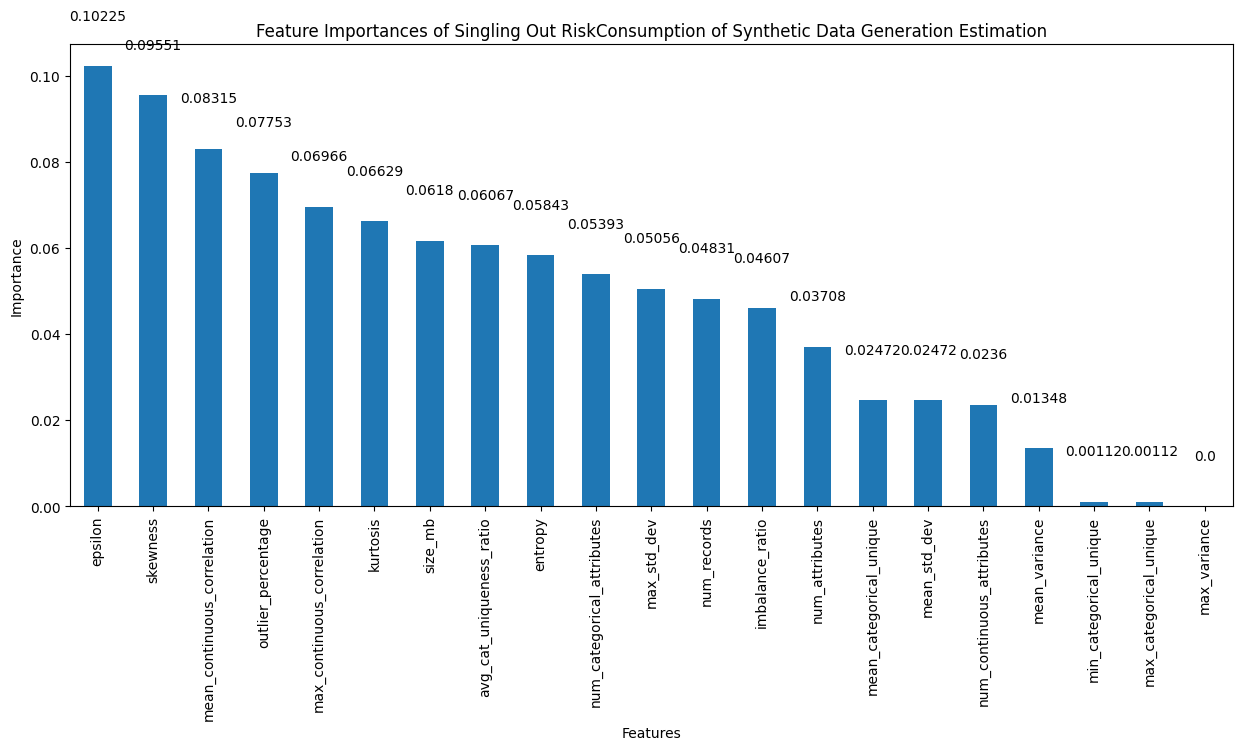

In [30]:
a, aa, aaa, all_importances_regular = lightgbm_ml(data, features, target_ml, 0.19, 0, 100, 0.1)
# a, aa, aaa, all_importances_regular = lightgbm_ml(data, features_descending, target_ml, 0.19, 0, 100, 0.1)


importances_sorted = all_importances_regular.sort_values(ascending=False)
# pd.options.display.float_format = '{:.4f}'.format

importances_sorted = importances_sorted.round(5)
print(importances_sorted)

# Plot the feature importances
plt.figure(figsize=(15, 6))
ax = importances_sorted.plot(kind='bar')
for i, v in enumerate(importances_sorted.values):
    ax.text(i, v + 0.01, f'{v}', ha='center', va='bottom')
plt.title('Feature Importances of Singling Out RiskConsumption of Synthetic Data Generation Estimation')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('singling_out_importances.png')
plt.show()
lists_ttt = [importances_sorted[:(i)].index.to_list() for i in range(5, 21)]


In [28]:
#LightGBM
start_time_total = datetime.now()

ests = [100]
for l in lists_ttt:
    start_time = datetime.now()
    for i in range(4, len(l)):
        print(f'\r{i - 3} out of {len(l) - 4 }', end='\r',  flush=True)
        for es in ests:
            
            sfs_params, sfs_features, o_r2, o_mse, selected_features_df, o_acc = our_sfs_ml(
                        dataset=data, test_size=0.19, our_features=l, 
                        estimators=es, learning_rate=0.1, depth=-1, n_features=i, scalee=0, direction_s='forward'
                    )
            if o_r2 < 0.2:
                continue
            print(f'Learning rate: 0.1')
            print(f'Estimators: {es}')
            print(f'Input Features: {l}')
            print(f'Number of Features to choose {i}')
            print(sfs_features)
            print(f'R2: {o_r2}')
            print( f'MSE: {o_mse}')
            print(  selected_features_df)
            print(f'Comparison Accuracy: {o_acc}')
            print('\n')


    end_time = datetime.now()

    elapsed_time = (end_time - start_time).total_seconds() / 60

    print(f"Elapsed time: {elapsed_time:.2f} minutes with list size {len(l)}")
end_time_total = datetime.now()

elapsed_time_total = (end_time_total - start_time_total).total_seconds() / 60

print(f"Total lapsed time: {elapsed_time_total:.2f} minutes")
"""  

5 minutes
 """

Elapsed time: 0.01 minutes with list size 5
Elapsed time: 0.01 minutes with list size 6
Elapsed time: 0.03 minutes with list size 7
Elapsed time: 0.04 minutes with list size 8
Elapsed time: 0.06 minutes with list size 9
Elapsed time: 0.09 minutes with list size 10
Elapsed time: 0.12 minutes with list size 11
Elapsed time: 0.15 minutes with list size 12
Elapsed time: 0.20 minutes with list size 13
Elapsed time: 0.27 minutes with list size 14
Elapsed time: 0.36 minutes with list size 15
Elapsed time: 0.43 minutes with list size 16
Elapsed time: 0.49 minutes with list size 17
Elapsed time: 0.60 minutes with list size 18
Elapsed time: 0.72 minutes with list size 19
Elapsed time: 0.86 minutes with list size 20
Total lapsed time: 4.45 minutes


'  \n\n5 minutes\n '

In [31]:
#LightGBM
start_time_total = datetime.now()

ests = [100]
for l in lists_ttt:
    start_time = datetime.now()
    for i in range(4, len(l)):
        print(f'\r{i - 3} out of {len(l) - 4 }', end='\r',  flush=True)
        for es in ests:
            
            sfs_params, sfs_features, o_r2, o_mse, selected_features_df, o_acc = our_sfs_ml(
                        dataset=data, test_size=0.19, our_features=l, 
                        estimators=es, learning_rate=0.1, depth=-1, n_features=i, scalee=0, direction_s='backward'
                    )
            if o_r2 < 0.2:
                continue
            print(f'Learning rate: 0.1')
            print(f'Estimators: {es}')
            print(f'Input Features: {l}')
            print(f'Number of Features to choose {i}')
            print(sfs_features)
            print(f'R2: {o_r2}')
            print( f'MSE: {o_mse}')
            print(  selected_features_df)
            print(f'Comparison Accuracy: {o_acc}')
            print('\n')


    end_time = datetime.now()

    elapsed_time = (end_time - start_time).total_seconds() / 60

    print(f"Elapsed time: {elapsed_time:.2f} minutes with list size {len(l)}")
end_time_total = datetime.now()

elapsed_time_total = (end_time_total - start_time_total).total_seconds() / 60

print(f"Total lapsed time: {elapsed_time_total:.2f} minutes")
"""  
16 minutes
Learning rate: 0.1
Estimators: 100
Input Features: ['epsilon', 'skewness', 'mean_continuous_correlation', 'outlier_percentage', 'max_continuous_correlation', 'kurtosis', 'size_mb', 'avg_cat_uniqueness_ratio', 'entropy', 'num_categorical_attributes', 'max_std_dev', 'num_records', 'imbalance_ratio', 'num_attributes', 'mean_categorical_unique', 'mean_std_dev']
Number of Features to choose 14
['epsilon', 'mean_continuous_correlation', 'outlier_percentage', 'max_continuous_correlation', 'kurtosis', 'size_mb', 'avg_cat_uniqueness_ratio', 'entropy', 'max_std_dev', 'num_records', 'imbalance_ratio', 'num_attributes', 'mean_categorical_unique', 'mean_std_dev']
R2: 0.22152515134325812
MSE: 3.242626187255386e-05
                       Feature  Importance  Importance_Percentage
4                     kurtosis         126              14.000000
2           outlier_percentage         105              11.666667
0                      epsilon          95              10.555556
6     avg_cat_uniqueness_ratio          80               8.888889
7                      entropy          75               8.333333
1   mean_continuous_correlation          71               7.888889
3    max_continuous_correlation          69               7.666667
9                  num_records          59               6.555556
5                      size_mb          58               6.444444
10             imbalance_ratio          55               6.111111
8                  max_std_dev          33               3.666667
13                mean_std_dev          28               3.111111
11              num_attributes          26               2.888889
12     mean_categorical_unique          20               2.222222
Comparison Accuracy: 72.41379310344827
5 minutes
 """

Elapsed time: 0.00 minutes with list size 5
Elapsed time: 0.01 minutes with list size 6
Elapsed time: 0.01 minutes with list size 7
Elapsed time: 0.03 minutes with list size 8
Elapsed time: 0.04 minutes with list size 9
Elapsed time: 0.07 minutes with list size 10
Elapsed time: 0.09 minutes with list size 11
Elapsed time: 0.13 minutes with list size 12
Elapsed time: 0.18 minutes with list size 13
Elapsed time: 0.23 minutes with list size 14
Learning rate: 0.1
Estimators: 100
Input Features: ['epsilon', 'skewness', 'mean_continuous_correlation', 'outlier_percentage', 'max_continuous_correlation', 'kurtosis', 'size_mb', 'avg_cat_uniqueness_ratio', 'entropy', 'num_categorical_attributes', 'max_std_dev', 'num_records', 'imbalance_ratio', 'num_attributes', 'mean_categorical_unique']
Number of Features to choose 14
['epsilon', 'skewness', 'mean_continuous_correlation', 'outlier_percentage', 'max_continuous_correlation', 'kurtosis', 'size_mb', 'avg_cat_uniqueness_ratio', 'entropy', 'max_std_d

"  \n16 minutes\nLearning rate: 0.1\nEstimators: 100\nInput Features: ['epsilon', 'skewness', 'mean_continuous_correlation', 'outlier_percentage', 'max_continuous_correlation', 'kurtosis', 'size_mb', 'avg_cat_uniqueness_ratio', 'entropy', 'num_categorical_attributes', 'max_std_dev', 'num_records', 'imbalance_ratio', 'num_attributes', 'mean_categorical_unique', 'mean_std_dev']\nNumber of Features to choose 14\n['epsilon', 'mean_continuous_correlation', 'outlier_percentage', 'max_continuous_correlation', 'kurtosis', 'size_mb', 'avg_cat_uniqueness_ratio', 'entropy', 'max_std_dev', 'num_records', 'imbalance_ratio', 'num_attributes', 'mean_categorical_unique', 'mean_std_dev']\nR2: 0.22152515134325812\nMSE: 3.242626187255386e-05\n                       Feature  Importance  Importance_Percentage\n4                     kurtosis         126              14.000000\n2           outlier_percentage         105              11.666667\n0                      epsilon          95              10.555556

In [7]:
best_features_1 = ['epsilon', 'skewness', 'mean_continuous_correlation', 'outlier_percentage', 'max_continuous_correlation', 
                   'kurtosis', 'size_mb', 'avg_cat_uniqueness_ratio', 'entropy', 'max_std_dev', 'num_records', 'imbalance_ratio', 
                   'num_attributes', 'mean_categorical_unique']



best_model, best_predictions, best_actual, best_importances  = lightgbm_ml(data, best_features_1, target_ml, 0.19, 0, 100, 0.1)



Conditions for singling_out_risk:
LightGBM Regression
Number of Estimators: 100
Learning Rate: 0.1
Best MSE: 0.0000312272
Best R²: 0.2503122666
Test size: 0.19
Best Feature Combination: ['epsilon', 'skewness', 'mean_continuous_correlation', 'outlier_percentage', 'max_continuous_correlation', 'kurtosis', 'size_mb', 'avg_cat_uniqueness_ratio', 'entropy', 'max_std_dev', 'num_records', 'imbalance_ratio', 'num_attributes', 'mean_categorical_unique']
Accuracy: 20.689655172413794%
Feature Importances:
epsilon                        0.099435
skewness                       0.117514
mean_continuous_correlation    0.092655
outlier_percentage             0.122034
max_continuous_correlation     0.089266
kurtosis                       0.075706
size_mb                        0.031638
avg_cat_uniqueness_ratio       0.064407
entropy                        0.071186
max_std_dev                    0.030508
num_records                    0.074576
imbalance_ratio                0.064407
num_attributes    

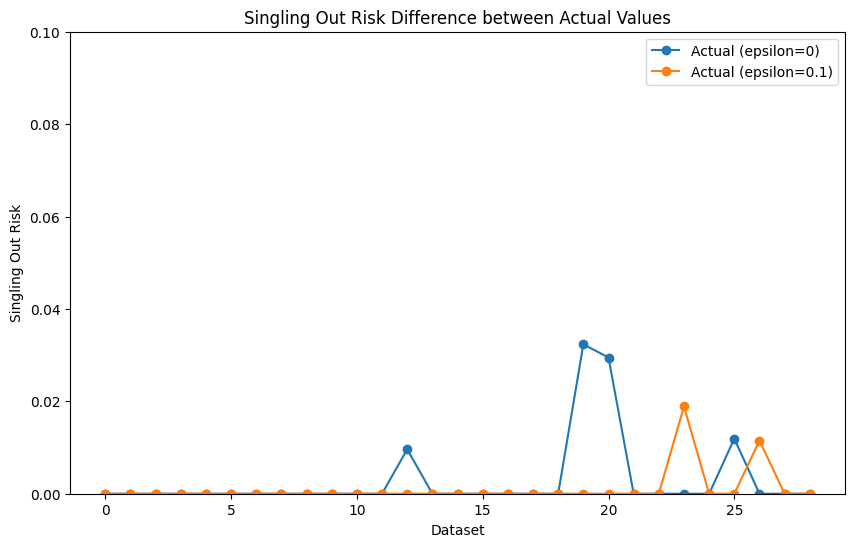

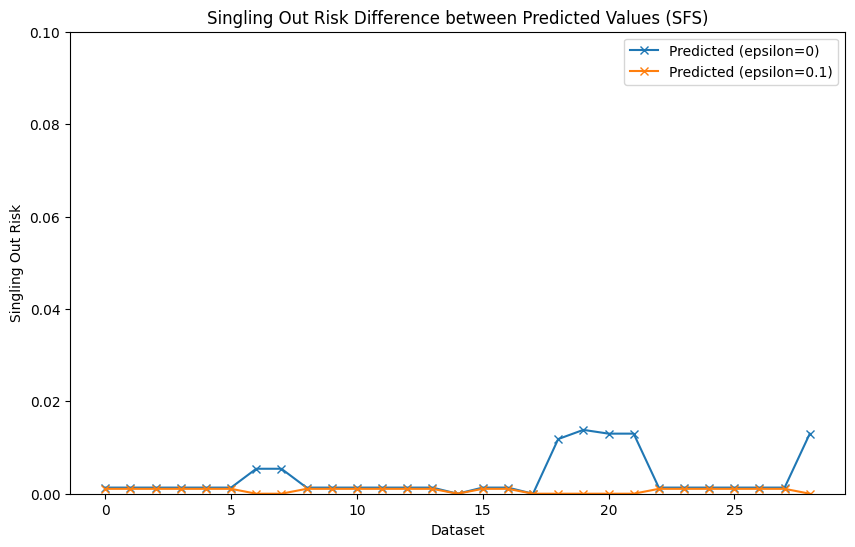

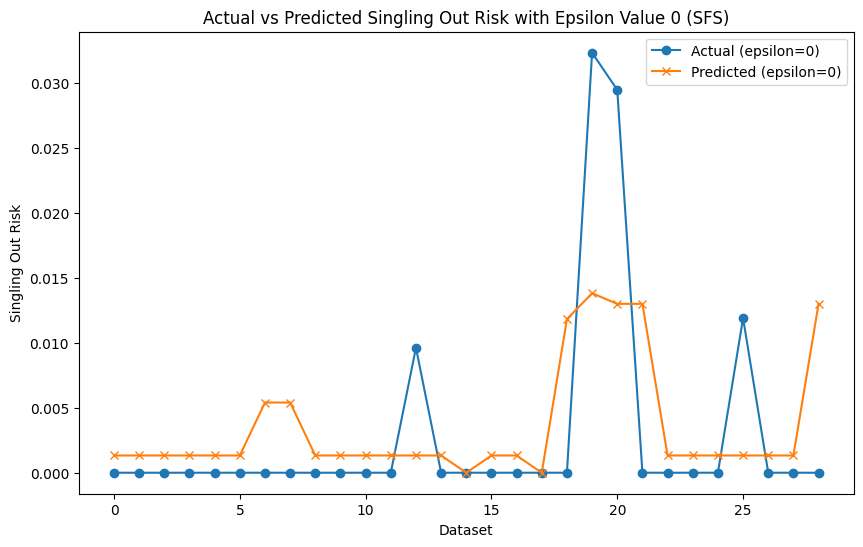

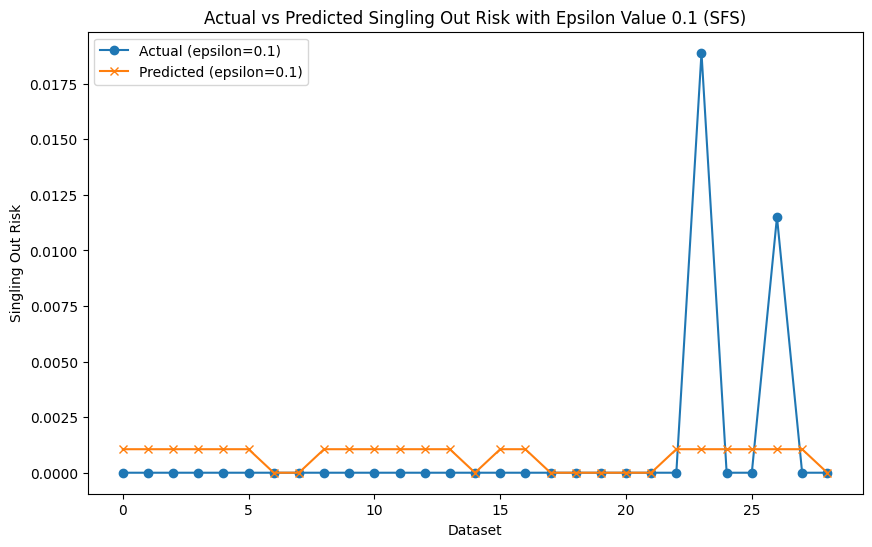

In [8]:
import matplotlib.pyplot as plt

# Separate the data by epsilon
best_actual_0 = [best_actual[i] for i in range(0, len(best_actual), 2)]   # Actual values for epsilon 0
best_actual_01 = [best_actual[i] for i in range(1, len(best_actual), 2)]  # Actual values for epsilon 0.1
y_pred_0 = [best_predictions[i] for i in range(0, len(best_predictions), 2)]  # Predicted values for epsilon 0
y_pred_01 = [best_predictions[i] for i in range(1, len(best_predictions), 2)] # Predicted values for epsilon 0.1


x_indices_0 = range(len(best_actual_0))     # Indices for epsilon 0
x_indices_01 = range(len(best_actual_01))   # Indices for epsilon 0.1
y_min = 0
# y_max = max(max(best_actual_0), max(best_actual_01), max(y_pred_0), max(y_pred_01)) + 0.1
y_max = 0.1
# Plot 1: Difference between actual values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, best_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_01, best_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.ylim(y_min, y_max)
plt.title('Singling Out Risk Difference between Actual Values')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
# plt.savefig('singling_out_difference_between_actual_values.png')  
plt.show()

# Plot 2: Difference between predicted values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.ylim(y_min, y_max)
plt.title('Singling Out Risk Difference between Predicted Values (SFS)')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
plt.savefig('singling_out_difference_between_predicted_values.png')  
plt.show()

# Plot 3: Actual vs Predicted for epsilon 0
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, best_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.title('Actual vs Predicted Singling Out Risk with Epsilon Value 0 (SFS)')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
plt.savefig('singling_out_actual_vs_predicted_epsilon_0.png')  
plt.show()

# Plot 4: Actual vs Predicted for epsilon 0.1
plt.figure(figsize=(10, 6))
plt.plot(x_indices_01, best_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.title('Actual vs Predicted Singling Out Risk with Epsilon Value 0.1 (SFS)')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
plt.savefig('singling_out_actual_vs_predicted_epsilon_01.png')  
plt.show()


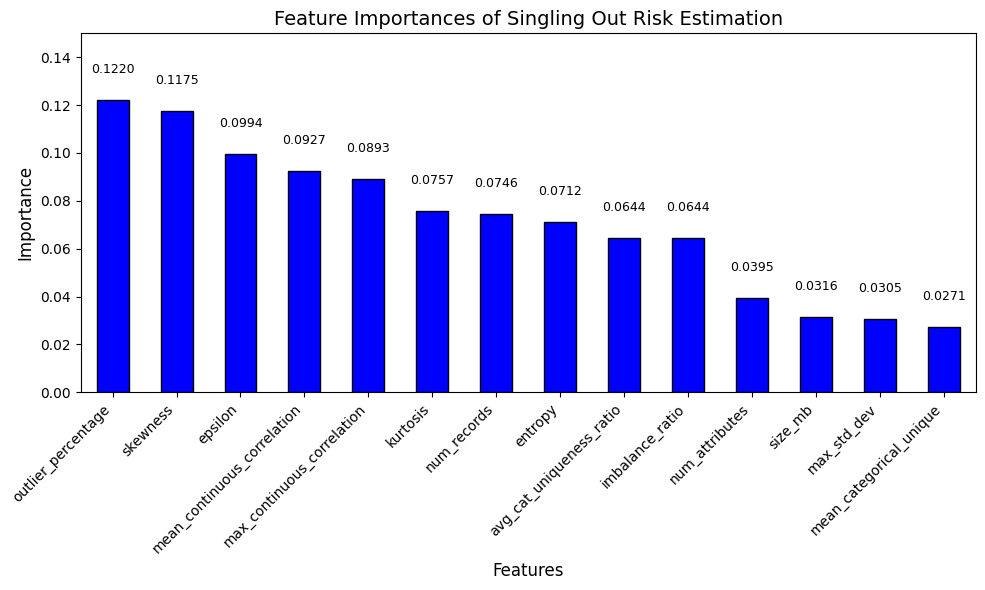

In [34]:
importances_sorted = best_importances.sort_values(ascending=False)

# Set display options for rounded float format
pd.options.display.float_format = '{:.3f}'.format  # Set to 3 decimal places

# Plot the feature importances
plt.figure(figsize=(10, 6))
ax = importances_sorted.plot(kind='bar', color='blue', edgecolor='black')

# Add rounded values above bars
for i, v in enumerate(importances_sorted.values):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontsize=9)  # Rounded to 3 decimals

# Improve axis labels and title
plt.title('Feature Importances of Singling Out Risk Estimation', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.ylim(0, 0.15)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate feature names for better readability
plt.tight_layout()  # Adjust layout to fit all elements

plt.savefig('singling_out_importances.png')
plt.show()

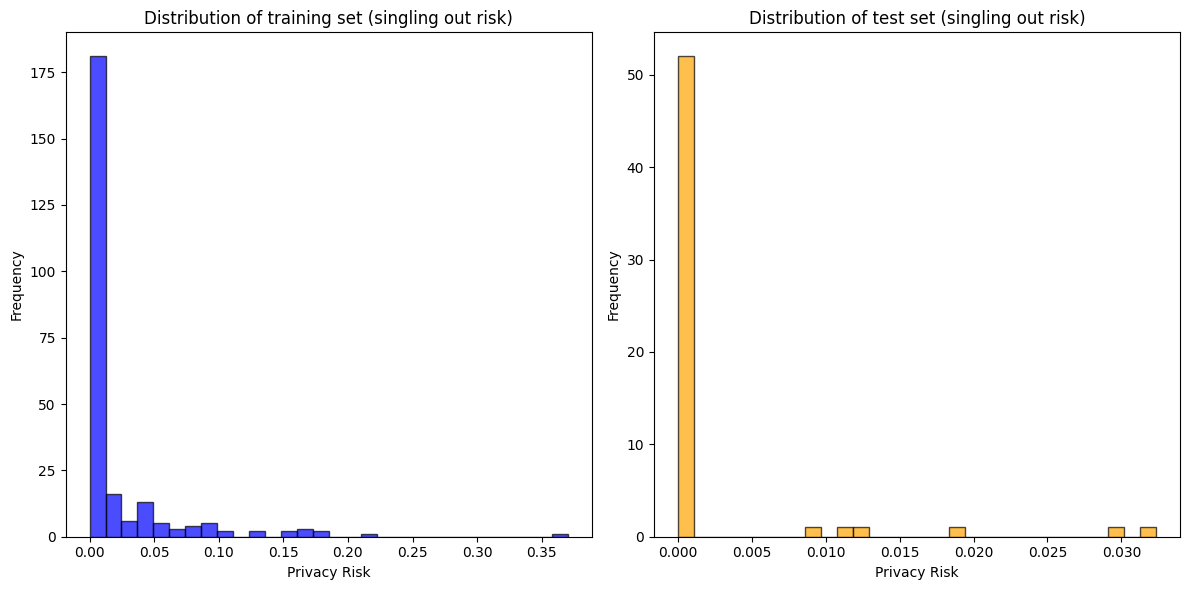

In [35]:
split_index = int((1 - 0.19)* len(data))
if split_index % 2 != 0:
    split_index += 1
y = data[target_ml]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

plt.figure(figsize=(12, 6))

# Histogram for y_train
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of training set (singling out risk)')
plt.xlabel('Privacy Risk')
plt.ylabel('Frequency')

# Histogram for y_test
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution of test set (singling out risk)')
plt.xlabel('Privacy Risk')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('singling_out_distribution.png')
plt.show()